# Load Libraries
### *If you need other libraries, you can add by yourself* ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import accuracy_score

# Load DataSets
## Since the dataset is quite large, restrict yourself to the first 2000 images as raw data, and then split it into training and testing datasets via ratio 8:2.（The raw data should be a 2000 × 784 matrix，check the shape after you get the dataset and split）

In [3]:
mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist["data"], mnist["target"]

#code here
X = X[:2000]
Y = Y[:2000]
print(X.shape)
print(Y.shape)

(2000, 784)
(2000,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

# Build Model
## This part you can simply build the K-means model(k = 10) and print the predicted labels

In [26]:
#code here
model = KMeans(n_clusters = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.labels_)

[7 3 3 ... 9 3 8]


below is the example code for plotting the cluster center

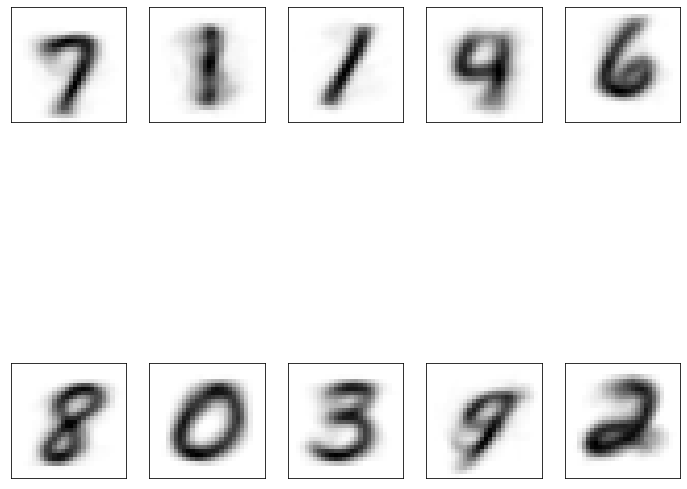

In [27]:
fig, ax = plt.subplots(2, 5, figsize = (12, 12))
centers = model.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

***There are some example codes for matching labels with clusters***

*We can use kmeans.labels_ to print the predicted labels. But these are not real label of each image, since the output of the kmeans.labels_ is just group id for clustering. For example, 6 in kmeans.labels_ has similar features with another 6 in kmeans.labels_.* There is no more meaning from the label.

To match it with real label, we can tackle the follow things:


*   Combine each images in the same group
*   Check Frequency distribution of actual labels (using np.bincount)
*   Find the Maximum frequent label (through np.argmax), and set the label.

In [32]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

You can try to print the result via this two functions

In [40]:
cluster_labels = infer_cluster_labels(model, y_train.to_numpy(dtype = np.int64))
predicted_labels = infer_data_labels(y_pred, cluster_labels)
print(predicted_labels)

[4 1 2 1 7 4 6 6 5 3 1 4 6 3 6 1 0 3 1 3 7 3 3 5 4 1 6 3 2 1 1 0 1 7 8 6 3
 7 5 5 4 8 2 0 3 0 5 3 6 3 7 8 2 2 2 3 0 6 5 1 2 4 8 1 5 6 3 1 1 4 1 3 3 4
 4 3 7 5 7 1 3 1 4 0 5 6 1 4 5 1 7 7 4 8 4 8 8 4 1 3 2 5 1 1 8 4 1 7 2 1 5
 0 1 0 3 7 1 6 0 1 2 4 6 3 1 3 1 0 3 1 5 7 7 6 0 6 7 4 0 0 0 0 3 1 1 7 1 0
 6 4 4 8 1 3 4 4 0 1 4 5 6 5 4 6 4 5 1 0 1 3 3 5 7 7 5 1 5 4 5 6 7 5 3 7 1
 6 0 2 5 4 2 1 2 0 5 4 3 2 6 8 3 3 1 4 1 4 7 1 1 2 5 0 1 2 7 1 8 4 1 3 8 1
 8 5 8 1 0 7 8 4 5 5 2 4 5 8 0 0 3 2 1 8 3 5 2 1 1 0 8 7 8 1 5 3 5 1 4 1 6
 6 0 0 0 1 1 1 7 4 1 6 3 5 5 3 1 6 8 1 1 5 4 0 3 0 7 4 2 3 3 4 1 4 4 6 1 1
 1 1 5 8 1 4 6 3 4 4 3 8 0 7 0 7 4 5 4 8 5 5 7 5 6 4 3 1 5 1 0 7 1 1 1 1 1
 7 5 8 1 3 5 3 1 1 8 6 1 6 4 4 7 1 5 3 3 6 1 2 8 2 4 1 1 2 3 0 0 4 3 8 0 4
 4 8 4 1 7 1 8 0 0 1 0 6 5 6 4 1 6 3 8 5 3 5 4 2 6 1 8 3 4 0]


# Evaluating Clustering Algorithm
### Since we are using this clustering algorithm for classification, accuracy is ultimately the most important metric;

### Furthermore, earlier we made the assumption that K = 10 was the appropriate number of clusters; however, this might not be the case. Let's fit the K-means clustering algorithm with several different values of K, than evaluate the performance using our metrics.

In [41]:
# this is the code for  other metrics out there that can be applied directly to the clusters themselves, regardless of the associated labels. 
# Two of these metrics that we will use are inertia and homogeneity.
# If you want, you can use it when you print the accuracy
def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertia
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Homogeneity Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    return inertia, homogeneity

In [46]:
clusters = [10, 16, 36, 64, 144, 256]
acc_list = []
for i in range(len(clusters)):
    kmeans = KMeans(n_clusters = clusters[i])
    kmeans.fit(X_train, y_train)
    pred = kmeans.predict(X_test)
    c_labels = infer_cluster_labels(kmeans, y_train.to_numpy(dtype = np.int64))
    p_labels = infer_data_labels(pred, c_labels)
    acc_list.append(accuracy_score(y_test.to_numpy(dtype = np.int64), p_labels))
print(acc_list)

[0.5675, 0.6825, 0.7225, 0.76, 0.835, 0.845]


# Plot the Accuracy Result

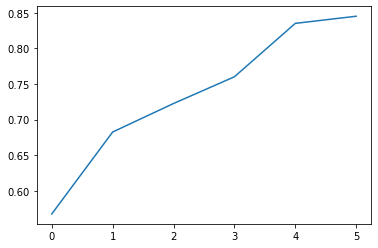

In [47]:
from matplotlib import pyplot as plt

plt.plot(acc_list)
plt.show()

# Predict the Testing Dataset
Using the best k from above result and get the accuracy

In [48]:
kmeans = KMeans(n_clusters = 256)
kmeans.fit(X_train, y_train)
pred = kmeans.predict(X_test)
c_labels = infer_cluster_labels(kmeans, y_train.to_numpy(dtype = np.int64))
p_labels = infer_data_labels(pred, c_labels)
print(accuracy_score(y_test.to_numpy(dtype = np.int64), p_labels))

0.8525
